In [1]:
# libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files
import os
for dirname, _, filenames in os.walk('data/fer2013-kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


data/fer2013-kaggle/test.csv
data/fer2013-kaggle/fer2013.csv
data/fer2013-kaggle/fer2013.bib
data/fer2013-kaggle/README
data/fer2013-kaggle/icml_face_data.csv
data/fer2013-kaggle/train.csv


In [2]:
# sample file path
SAMPLE_FILE_PATH = "data/fer2013-kaggle/icml_face_data.csv"

# number of categories
NUM_CLASSES = 7

# The output path of HDF5 files for training, verification, and testing datasets
TRAIN_HDF5 = "train.hdf5"
VAL_HDF5 = "val.hdf5"
TEST_HDF5 = "test.hdf5"

# Number of samples per batch
BATCH_SIZE = 128

# Project output file save directory
OUTPUT_PATH = "data/working_model"

# Model save location and file name
MODEL_FILE = OUTPUT_PATH + "/model.h5"

In [3]:
import os
import h5py


# HDF5DatasetWriter class
class HDF5DatasetWriter:
    def __init__(self, dims, output_path, data_key="images", buf_size=1000):
        # Check if the output path exists, and throw an exception if it exists
        if os.path.exists(output_path):
            raise ValueError('The output file {} you provided already exists, please delete it manually first!'.format(output_path))

        # Create and open a writable HDF5 file
        # Then create two datasets in it, one to store images/features and the 
        # other to store classification labels
        self.db = h5py.File(output_path, "w")
        self.data = self.db.create_dataset(data_key, dims, dtype="float")
        self.labels = self.db.create_dataset("labels", (dims[0],), dtype="int")

        # Save the cache size, then initialize the cache and dataset index
        self.buf_size = buf_size
        self.buffer = {"data": [], "labels": []}
        self.idx = 0

    def add(self, raw, label):
        # Add data and tags to the cache
        self.buffer["data"].extend(raw)
        self.buffer["labels"].extend(label)

        if len(self.buffer["data"]) >= self.buf_size:
            self.flush()

    def flush(self):
        # Write the cache content to a disk file, then clear the cache
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx:i] = self.buffer["data"]
        self.labels[self.idx:i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}

    def store_class_labels(self, class_labels):
        # Create a data set to store the classification label name, 
        # and then save the classification label
        dt = h5py.special_dtype(vlen=str)
        label_dim = (len(class_labels),)
        label_set = self.db.create_dataset("label_names", label_dim, dtype=dt)
        label_set[:] = class_labels

    def close(self):
        # Check if there is a record in the cache, if so, 
        # it must be written to the disk file
        if len(self.buffer["data"]) > 0:
            self.flush()

        # Close the dataset
        self.db.close()


In [4]:
import numpy as np

print("Loading CSV dataset file...")
# Open the CSV format dataset file
file = open(SAMPLE_FILE_PATH)

# Skip the first row (header)
file.__next__()

# Declare training, validation, and test datasets
(train_images, train_labels) = ([], [])
(val_images, val_labels) = ([], [])
(test_images, test_labels) = ([], [])

count_by_label_train = {}
count_by_label_val = {}
count_by_label_test = {}
# loop through each line of the file
for row in file:
    # Extract the label, usage, and image of each row
    (label, usage, image) = row.strip().split(",")
    # label to integer
    label = int(label)
    if NUM_CLASSES == 6:
        if label == 1:
            label = 0
        if label > 0:
            label -= 1
    # Convert the one-dimensional pixel list into a 48x48 grayscale image
    image = np.array(image.split(" "), dtype="uint8")
    image = image.reshape((48, 48))

    # If the data is the training data, add it to the training set
    if usage == "Training":
        train_images.append(image)
        train_labels.append(label)
        count = count_by_label_train.get(label, 0)
        count_by_label_train[label] = count + 1
    # If the data is the PublicTest dataset, add it to the validation set
    elif usage == "PublicTest":
        val_images.append(image)
        val_labels.append(label)
        count = count_by_label_val.get(label, 0)
        count_by_label_val[label] = count + 1
    # If the data is the PrivateTest dataset, add it to the test set
    elif usage == "PrivateTest":
        test_images.append(image)
        test_labels.append(label)
        count = count_by_label_test.get(label, 0)
        count_by_label_test[label] = count + 1

# Close the CVS sample file
file.close()

# Output the number of training, validation and testing samples
print("Number of training samples: {}".format(len(train_images)))
print("Number of validation samples: {}".format(len(val_images)))
print("Number of test samples: {}".format(len(test_images)))
print("Training sample distribution: ")
print(count_by_label_train)
print("Validation sample distribution: ")
print(count_by_label_val)
print("Test sample distribution: ")
print(count_by_label_test)


# Build a list of training, validation, and test datasets
# Each element is composed of dataset type name, all sample file names,
# all sample integer labels, and their HDF5 output file
datasets = [(train_images, train_labels, TRAIN_HDF5),
            (val_images, val_labels, VAL_HDF5),
            (test_images, test_labels, TEST_HDF5)]

# Loop through the dataset tuples
for (images, labels, outputPath) in datasets:
    # create HDF5 writer
    print("Building {}...".format(outputPath))
    writer = HDF5DatasetWriter((len(images), 48, 48), outputPath)

    # Loop through each image and add it to the dataset
    for (image, label) in zip(images, labels):
        writer.add([image], [label])

    # Close the HDF5 writer
    writer.close()


Loading CSV dataset file...
Number of training samples: 28709
Number of validation samples: 3589
Number of test samples: 3589
Training sample distribution: 
{0: 3995, 2: 4097, 4: 4830, 6: 4965, 3: 7215, 5: 3171, 1: 436}
Validation sample distribution: 
{0: 467, 1: 56, 4: 653, 6: 607, 3: 895, 2: 496, 5: 415}
Test sample distribution: 
{0: 491, 5: 416, 6: 626, 4: 594, 2: 528, 3: 879, 1: 55}
Building train.hdf5...
Building val.hdf5...
Building test.hdf5...


In [5]:
from tensorflow.keras.preprocessing.image import img_to_array


# ImageToArrayPreprocessor class
class ImageToArrayPreprocessor:
    def __init__(self, data_format=None):
        # Format to save image data
        self.data_format = data_format

    def preprocess(self, image):
        """
        Reset the dimensions of the image

        Args:
            image: the image to preprocess

        Returns:
            The image after dimension reset
        """

        # Call the img_to_array method of tensorflow.keras to correctly reset the dimensions of the image
        return img_to_array(image, data_format=self.data_format)


2022-12-09 13:59:31.712127: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [6]:
from tensorflow.python.keras.utils import np_utils
import numpy as np
import h5py


class HDF5DatasetGenerator:
    def __init__(self,
                 db_file,
                 batch_size,
                 preprocessors=None,
                 aug=None,
                 binarize=True,
                 classes=2):
        # Number of samples per batch
        self.batchSize = batch_size

        # list of preprocessors
        self.preprocessors = preprocessors

        # Data enhancement processor list, you can use the data enhancement
        # algorithm implemented by tf.keras.preprocessing.image.ImageDataGenerator
        self.aug = aug

        # Whether the label is binarized, the category labels we save in the HDF5 dataset
        # are a list of single integers, however, when we use categorical cross-entropy
        # or binary cross-entropy as the calculation loss method,
        # we have to binarize labels into one-hot encoded vectors
        self.binarize = binarize

        # The number of unique categories, this value is required 
        # when calculating the label binarization one-hot encoding vector group
        self.classes = classes

        # Open the HDF5 dataset file
        self.db = h5py.File(db_file, "r")

        # Number of samples in the dataset
        self.numImages = self.db["labels"].shape[0]

    def generator(self, passes=np.inf):
        # Initialize training times counter
        epochs = 0

        # Execute an infinite loop, once the specified number
        # of training times is reached, the model will automatically
        # stop training
        while epochs < passes:
            # Traverse the HDF5 dataset
            for i in np.arange(0, self.numImages, self.batchSize):
                # Take a batch of samples and labels from the HDF5 dataset
                images = self.db["images"][i: i + self.batchSize]
                labels = self.db["labels"][i: i + self.batchSize]

                # Check if the label has been converted to a one-hot encoded vector set
                if self.binarize:
                    labels = np_utils.to_categorical(labels, self.classes)

                # if preprocessor is present
                if self.preprocessors is not None:
                    # Initialize the list of preprocessed result images
                    processed_images = []

                    # iterate through images
                    for image in images:
                        # Iterate through the preprocessors, performing all preprocessing on each image
                        for p in self.preprocessors:
                            image = p.preprocess(image)

                        # Update the preprocessing result image list
                        processed_images.append(image)

                    # Update the image array to the preprocessed result image
                    images = np.array(processed_images)

                # If a data enhancer is specified, implement it
                if self.aug is not None:
                    (images, labels) = next(self.aug.flow(images,
                                                          labels,
                                                          batch_size=self.batchSize))

                # generate images and tag tuples
                yield images, labels

            # Increase the number of training passes counter
            epochs += 1

    def close(self):
        # Close the HDF5 dataset
        self.db.close()

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend


# VGGNet class
class VGGNet:
    @staticmethod
    def build(width, height, channel, classes, reg=0.0002):
        """
        Create a VGGNet network model according to the dimensions 
        (width, height, channel) of the input sample, the number of categories,
        and the regularization factor
        
        Args:
            width: the width of the input sample
            height: the height of the input sample
            channel: the channel of the input sample
            classes: the number of categories
            reg: regularization factor

        Returns:
            VGGNet network model object

        """

        model = Sequential(name="VGGNet")

        # The default input format is "channels_last"
        shape = (height, width, channel)
        channel_dimension = -1

        # If the input format is channel prepended, reset the input format
        # and channel position indication
        if backend.image_data_format() == "channels_first":
            shape = (channel, height, width)
            channel_dimension = 1

        # first convolution block
        model.add(Conv2D(64, (3, 3), input_shape=shape, padding="same", kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dimension))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.35))

        # second convolution block
        model.add(Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dimension))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.35))

        # third convolution block
        model.add(Conv2D(256, (3, 3), padding="same", kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(Conv2D(256, (3, 3), padding="same", kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dimension))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.35))

        # fourth convolutional block
        model.add(Conv2D(512, (3, 3), padding="same", kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(Conv2D(512, (3, 3), padding="same", kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dimension))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.35))
        
        # first fully connected layer
        model.add(Flatten())
        model.add(Dense(1024, kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dimension))
        model.add(Dropout(0.5))

        # second fully connected layer
        model.add(Dense(256, kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dimension))
        model.add(Dropout(0.5))

        # third fully connected layer
        model.add(Dense(classes, kernel_regularizer=l2(reg)))
        model.add(Activation("softmax"))

        return model


# Test the VGGNet class instantiation and output the summary information 
# of the VGGNet model
if __name__ == "__main__":
    model = VGGNet.build(width=48, height=48, channel=1, classes=7, reg=0.0002)
    print(model.summary())

2022-12-09 13:59:32.698708: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-09 13:59:32.699397: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-09 13:59:32.769932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.56GiB deviceMemoryBandwidth: 648.29GiB/s
2022-12-09 13:59:32.769970: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-12-09 13:59:32.772676: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-12-09 13:59:32.772731: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-12-09 

Model: "VGGNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0    

In [8]:
# reduces learning rate on plateau
from tensorflow.keras.callbacks import ReduceLROnPlateau
learn_rate_fuc = ReduceLROnPlateau(monitor='val_accuracy',
                                   patience=2,
                                   verbose=1,
                                   factor=0.5,
                                   min_lr=0.000005)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax, Nadam
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

import argparse
import json
import os

# Set matplotlib to save plots in the background
# matplotlib.use("Agg")


# Training set data augmentation generator
train_aug = ImageDataGenerator(rotation_range=10,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               rescale=1 / 255.0,
                               fill_mode="nearest")
# Validation set data augmentation generator
val_aug = ImageDataGenerator(rescale=1 / 255.0)

# Initialize image preprocessor
iap = ImageToArrayPreprocessor()

# Initialize the training dataset generator
train_gen = HDF5DatasetGenerator(TRAIN_HDF5,
                                 BATCH_SIZE,
                                 aug=train_aug,
                                 preprocessors=[iap],
                                 classes=NUM_CLASSES)

# Initialize the validation dataset generator
val_gen = HDF5DatasetGenerator(VAL_HDF5,
                               BATCH_SIZE,
                               aug=val_aug,
                               preprocessors=[iap],
                               classes=NUM_CLASSES)

print("Compiling model...")

# Initialize the optimizer
weight_decay = 1e-4

opt = Adam(lr=1e-3)
# opt = Adamax()
# opt = Nadam()

model = VGGNet.build(width=48, height=48, channel=1, classes=NUM_CLASSES, reg=weight_decay)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

EPOCHS = 75

# Train the network
history = model.fit_generator(train_gen.generator(),
                              steps_per_epoch=train_gen.numImages // BATCH_SIZE,
                              validation_data=val_gen.generator(),
                              validation_steps=val_gen.numImages // BATCH_SIZE,
                              epochs=EPOCHS,
                              max_queue_size=BATCH_SIZE * 2,
                              callbacks=[learn_rate_fuc],
                              verbose=1)

# Save the trained model to a file
print("Saving trained model...")
model.save(MODEL_FILE, overwrite=True)

# Close the HDF5 dataset
train_gen.close()
val_gen.close()


Compiling model...


/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-09 13:59:34.230658: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-09 13:59:34.248682: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


Epoch 1/75


2022-12-09 13:59:35.441154: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-12-09 13:59:36.050350: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-12-09 13:59:36.055310: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-12-09 13:59:37.830026: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-12-09 13:59:37.898229: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-12-09 13:59:53.632037: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


224/224 [==============================] - 58s 64ms/step - loss: 2.9482 - accuracy: 0.1886 - val_loss: 2.2525 - val_accuracy: 0.2494
Epoch 2/75
224/224 [==============================] - 55s 55ms/step - loss: 2.3401 - accuracy: 0.2419 - val_loss: 2.1918 - val_accuracy: 0.2634
Epoch 3/75
224/224 [==============================] - 13s 60ms/step - loss: 2.1882 - accuracy: 0.2875 - val_loss: 2.0707 - val_accuracy: 0.3039
Epoch 4/75
224/224 [==============================] - 14s 62ms/step - loss: 2.0306 - accuracy: 0.3526 - val_loss: 2.0988 - val_accuracy: 0.2656
Epoch 5/75
224/224 [==============================] - 14s 61ms/step - loss: 1.8780 - accuracy: 0.4091 - val_loss: 1.7345 - val_accuracy: 0.4587
Epoch 6/75
224/224 [==============================] - 11s 50ms/step - loss: 1.7594 - accuracy: 0.4573 - val_loss: 1.6054 - val_accuracy: 0.5128
Epoch 7/75
224/224 [==============================] - 14s 63ms/step - loss: 1.6638 - accuracy: 0.4895 - val_loss: 1.6206 - val_accuracy: 0.5123
Epo

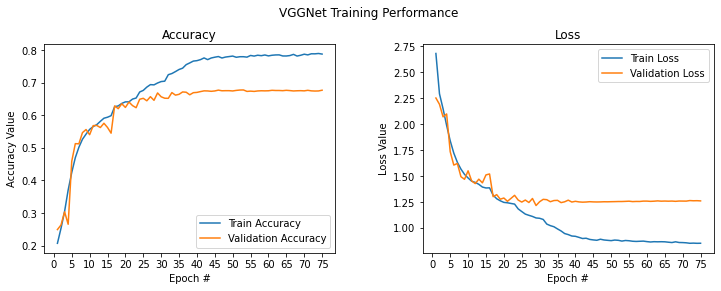

In [10]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGGNet Training Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, EPOCHS + 1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS + 1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS + 1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")